In [1]:
from pathlib import Path
import pickle
import itertools

import numpy as np
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

import nb_utils

In [2]:
def features_for_dim(pd, dim):
	# b: birth, d: death
	b, d, _ = pd[pd[:,2] == dim].T
	if dim == 0:
		assert d[-1] == np.inf
		d[-1] = 1
	with np.errstate(invalid='ignore', divide='ignore'):
		return [
			mean_bd := np.c_[b, d].mean(axis=0),
			mean_bd**2,
			np.nan_to_num(1/mean_bd + np.log(mean_bd)), # fix divide by zero
			np.c_[b, d].std(axis=0),
			[np.mean(b - d)],
			[np.mean(b - d)**2],
			[np.mean((b + d) / 2)],
			[np.mean((b + d) / 2)**2],
		]

features = {
	'avg_birth_death': 2,
	'avg_birth_death_squared': 2,
	'avg_birth_death_inverted' : 2,
	'std_birth_death': 2,
	'avg_life': 1,
	'avg_life_squared': 1,
	'avg_half_life': 1,
	'avg_half_life_squared': 1
}

def features_all_dims(pd):
	arrs = [np.concatenate(features_for_dim(pd, dim)) for dim in (0, 1)]
	return np.vstack(arrs)

In [3]:
# def get_labeled_data(task, sampler=None, exclude=[]):
# 	gen_gaps = nb_utils.gen_gaps
# 	candidates = [dir / (model + '.pd.npy') for model in gen_gaps]
# 	files = [file for file in candidates if file.exists() and not file in exclude]
# 	models = [file.stem.split('.')[0] for file in files]
# 	if len(models) < len(gen_gaps):
# 		print('Missing ', [m for m in gen_gaps if m not in models])
# 	pds = [*map(np.load, files)]
# 	X = np.stack([*map(features_all_dims, pds)])
# 	y = np.array([gen_gaps[m] for m in models])
# 	return X, y

def get_labeled_data(task, files):
	gen_gaps = nb_utils.gen_gaps[task]
	pds = [*map(np.load, files)]
	X = np.stack([*map(features_all_dims, pds)])
	y = np.array([gen_gaps[f.name.split('.')[0]] for f in files])
	return X, y

In [4]:
def feature_mask(included):
	return np.concatenate([
		np.full(length, 1 if feature in included else 0)
		for feature, length in features.items()
	])

def run_experiment(X, y, tries, model_fn):
	global features
	combinations = itertools.chain(*(
		itertools.combinations(features.keys(), r)
		for r in range(1, len(features) + 1)
	))
	results = {combo: [] for combo in combinations}
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for combo in tqdm(results):
		# Should I do cross-validation here?
		# and vary the splits over the different combos
		# or keep them the same?
		X_masked = X[:,:,np.where(feature_mask(combo))[0]]
		X_flattened = X_masked.reshape((len(X), -1))
		for train, test in splits:
			reg = model_fn().fit(X_flattened[train], y[train])
			results[combo] += [reg.score(X_flattened[test], y[test])]
	return results

## Model performance
We look at the model performance for the model with the best performing selection of features (by average R2) and at the models incorporating all features

In [5]:
def extract_best(results):
	return max(results.items(), key=lambda x: np.mean(x[1]))

def extract_all(results):
	return max(results.items(), key=lambda x: len(x[0]))

In [9]:
all_results = {}

for sampler, files in nb_utils.get_pd_files(1):
	print('Sampler: ', sampler)
	X, y = get_labeled_data(1, files)
	models = [file.name.split('.')[0] for file in files]
	if no_pd := [m for m in nb_utils.gen_gaps[1] if m not in models]:
		print('Missing ', no_pd)
	results = run_experiment(X, y, 500, LinearRegression)
	all_results[sampler] = results
	print('All features: ', np.mean(extract_all(results)[1]))
	print('Best selection:', np.mean(extract_best(results)[1]))
	print(extract_best(results)[0])
	print('\n\n')

Sampler:  stratifiedkmeans20000


100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


All features:  0.780870272463929
Best selection: 0.8232747134109238
('avg_birth_death_inverted', 'std_birth_death', 'avg_half_life', 'avg_half_life_squared')



Sampler:  stratifiedrandom
Missing  ['model_156', 'model_157']


100%|██████████| 255/255 [02:32<00:00,  1.67it/s]


All features:  0.7508428694430845
Best selection: 0.8023123615319212
('avg_birth_death_squared', 'avg_birth_death_inverted', 'std_birth_death', 'avg_life', 'avg_half_life_squared')



Sampler:  importance
Missing  ['model_156', 'model_157', 'model_158', 'model_220', 'model_221']


100%|██████████| 255/255 [02:19<00:00,  1.83it/s]


All features:  0.5536191848687495
Best selection: 0.7272161731437596
('avg_birth_death_squared', 'std_birth_death', 'avg_life_squared', 'avg_half_life', 'avg_half_life_squared')



Sampler:  random
Missing  ['model_28', 'model_29', 'model_156', 'model_157', 'model_159', 'model_220', 'model_221']


100%|██████████| 255/255 [02:22<00:00,  1.79it/s]

All features:  0.8184201055164978
Best selection: 0.8454333399319021
('avg_birth_death_squared', 'avg_birth_death_inverted', 'std_birth_death', 'avg_life', 'avg_life_squared')





### KDE plots

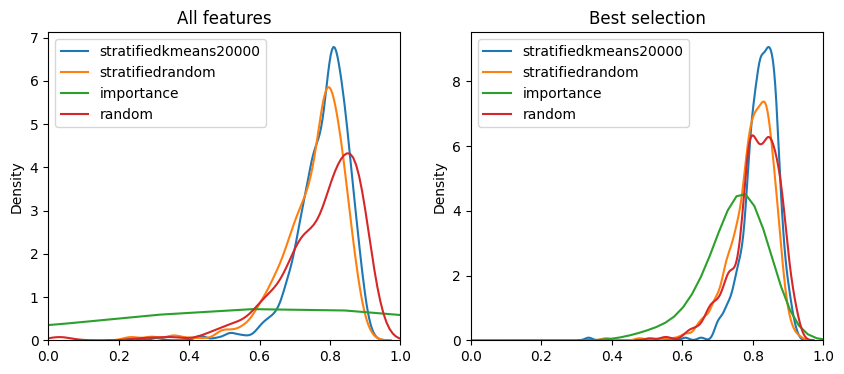

In [6]:
def plot_kdes(samplers, dists, bw=None, ax=None):
	for sampler, dist in zip(samplers, dists):
		ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=sampler)
	ax.legend()
	ax.set_xlim([0,1])
	return ax

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
types = {'All features': extract_all, 'Best selection': extract_best}
for ax, (title, extract) in zip(axs, types.items()):
	plot_kdes(samplers=list(all_results.keys()),
			dists=[extract(results)[1] for results in all_results.values()],
			ax=ax, bw=0.2)
	ax.set_title(title)

In [7]:
import pandas as pd

data = {
	sampler: [feature in extract_best(results)[0] for feature in features]
	for sampler, results in all_results.items()
}
pd.DataFrame(data, index=features.keys()).replace({True: 'X', False: ''})


,stratifiedkmeans20000,stratifiedrandom,importance,random
avg_birth_death,,,,X
avg_birth_death_squared,,X,X,
avg_birth_death_inverted,X,X,,X
std_birth_death,X,X,X,X
avg_life,,X,,
avg_life_squared,,,X,
avg_half_life,X,,X,X
avg_half_life_squared,X,X,,X


In [8]:
type(all_results['random'])

dict

In [9]:
from statistics import mean

heatmap = np.zeros((len(all_results), len(features)))
for i, (sampler, results) in enumerate(all_results.items()):
	for j, feature in enumerate(features):
		r2s = itertools.chain(
			*(r2s for combo, r2s in results.items() if feature in combo))
		heatmap[i][j] = mean(r2s)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Average R2 of selections with feature present'}>)

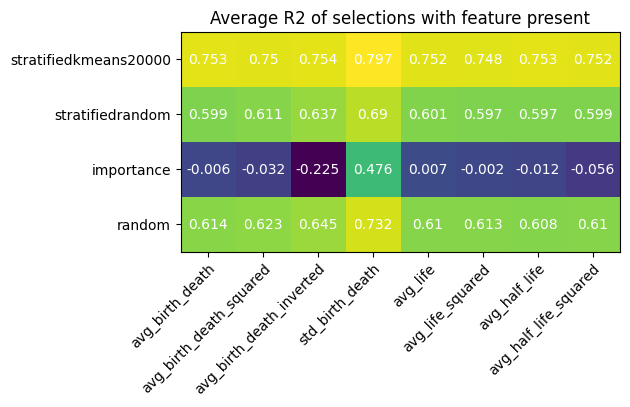

In [13]:
from importlib import reload
reload(nb_utils)

nb_utils.annotated_heatmap(heatmap,
						   title="Average R2 of selections with feature present",
						   x_labels=features.keys(),
						   y_labels=all_results.keys())

In [10]:
all_results = []
outdir = nb_utils.outdir / 'task1/random'
dirs = [*nb_utils.dirs(outdir)] + [outdir]
for dir in dirs:
	print('Sampler: ', dir.name)
	X, y = get_labeled_data(dir)
	results = run_experiment(X, y, 500, LinearRegression)
	all_results += [results]
	print('All features: ', np.mean(extract_all(results)[1]))
	print('Best selection:', np.mean(extract_best(results)[1]))
	print(extract_best(results)[0])
	print('\n\n')

Sampler:  22.12.21-20
Missing  ['model_28', 'model_29', 'model_93', 'model_156', 'model_157', 'model_158', 'model_220', 'model_221']


100%|██████████| 255/255 [02:15<00:00,  1.88it/s]


All features:  0.8303590382939303
Best selection: 0.8655390570129561
('avg_birth_death_squared', 'avg_birth_death_inverted', 'std_birth_death', 'avg_half_life')



Sampler:  22.12.21-18
Missing  ['model_28', 'model_29', 'model_156', 'model_157', 'model_159', 'model_220', 'model_221']


100%|██████████| 255/255 [02:04<00:00,  2.04it/s]


All features:  0.8161591245945992
Best selection: 0.8434533925296864
('avg_birth_death_squared', 'avg_birth_death_inverted', 'std_birth_death', 'avg_life', 'avg_life_squared')



Sampler:  random
Missing  ['model_28', 'model_29', 'model_156', 'model_157', 'model_220', 'model_221']


100%|██████████| 255/255 [02:05<00:00,  2.03it/s]

All features:  0.7714862918383598
Best selection: 0.8126884623891449
('avg_birth_death', 'avg_birth_death_inverted', 'std_birth_death', 'avg_half_life', 'avg_half_life_squared')





In [1]:
def plot_kdes(samplers, dists, bw=None, ax=None):
	for sampler, dist in zip(samplers, dists):
		ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=sampler)
	ax.set_xlim([0,1])
	return ax

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
types = {'All features': extract_all, 'Best selection': extract_best}
for ax, (title, extract) in zip(axs, types.items()):
	plot_kdes(samplers=['']*len(all_results),
			  dists=[extract(results)[1] for results in all_results],
			  ax=ax, bw=0.2)
	ax.set_title(title)

NameError: name 'plt' is not defined